In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import jax
from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

import sys
sys.path.append('../')

Jax is using: gpu


# Load data

In [119]:
import scipy
# mat = scipy.io.loadmat('../data/1_48_flash_deab_lens_plastic_25.mat')
mat = scipy.io.loadmat('../data/1_48_flash_deab_lens_25.mat')
# mat = scipy.io.loadmat('../data/1_48_flash_deab_25.mat')

/usr/local/lib/python3.10/dist-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [134]:
# define linear ultrasound transducer (P4-1)
nelements = mat['Trans']['numelements'][0,0][0,0] # number of transducer elements
element_pitch = mat['Trans']['spacingMm'][0,0][0,0]*1e-3 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = mat['Trans']['frequency'][0,0][0,0] * 1e6 # frequency of the transducer [Hz]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.028 m


In [147]:
raw_rf_data = mat['RcvData'][0,0]
raw_rf_data.shape

(4096, 64, 100)

In [190]:
from jwave.geometry import TimeAxis

dt = 1/(transducer_frequency * mat['Receive']['samplesPerWave'][0,0][0,0])
t_end = raw_rf_data.shape[0] * dt
time_axis = TimeAxis(dt, t_end)
t = time_axis.to_array()

In [191]:
from scipy.signal import resample
source_signal = np.squeeze(mat['TW']['Wvfm1Wy'][0,0])
new_num_samples = int((transducer_frequency * mat['Receive']['samplesPerWave'][0,0][0,0]) * len(source_signal) / 250e6)
source_signal = resample(source_signal, new_num_samples)

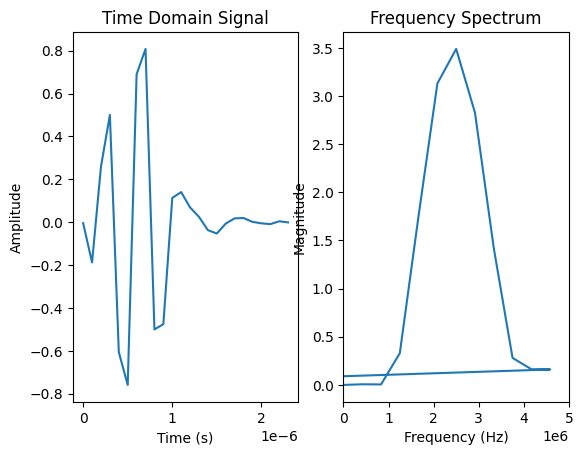

In [197]:
# Plot time-domain signal
plt.subplot(1, 2, 1)
plt.plot(t[:len(source_signal)], source_signal)
plt.title('Time Domain Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Compute and plot frequency spectrum
frequency = np.fft.fftfreq(source_signal.size, d=dt)
magnitude = np.abs(np.fft.fft(source_signal))
plt.subplot(1, 2, 2)
plt.plot(frequency, magnitude)
plt.xlim(0, 5e6)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [198]:
source_signal = np.pad(source_signal, (0, int(time_axis.Nt - source_signal.size)), 'constant')
source_signal.shape

(4096,)

In [242]:
connectorES = np.squeeze(mat['Trans']['ConnectorES'][0,0])
apodization = mat['apod']
apertureES = np.squeeze(mat['Trans']['HVMux'][0,0]['ApertureES'][0,0])
# apertureES = (apertureES[apertureES != 0] - 1)
# apertureES = (nelements - 1) - (apertureES[apertureES != 0] - 1)
np.sort(apertureES)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], dtype=uint8)

# Reconstruct

In [260]:
# define spatial parameters
N = np.array([128, 128]).astype(int) # grid size [grid points]
dx = np.array([element_pitch, element_pitch]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

# define transducer position in domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)

# filter for active transducers
element_positions = element_positions[:,:48]
element_positions

array([[ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  59,  60,  61,  62,  63],
       [108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
        108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
        108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
        108, 108, 108, 108, 108, 108, 108, 108, 108]])

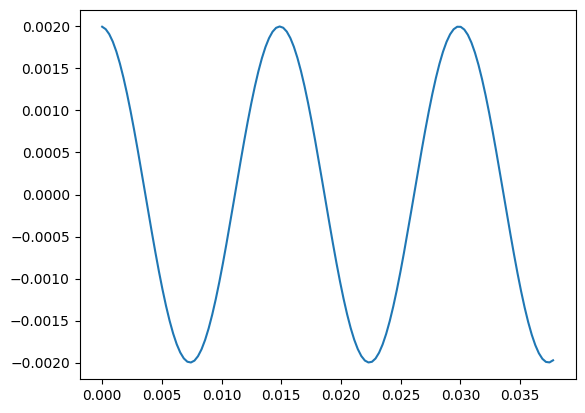

In [261]:
skull_thickness = round(6e-3 / dx[0]) # [gridpoints]
skull_distance_from_transducer = round(10e-3 / dx[0]) # [gridpoints]
speed = np.zeros(N)
skull_start_y = element_positions[1][0] - skull_distance_from_transducer
# speed[:, skull_start_y - skull_thickness:skull_start_y] = 1

x = np.linspace(0, N[0] * dx[0], N[0])
frequency = 1 / 0.015
amplitude = 2e-3
offset = 0e-3 
phase_shift = 2 * np.pi * frequency * (N[0]//2 * dx[0])
squiggle = amplitude * np.sin(2 * np.pi * frequency * x + phase_shift) + offset
plt.plot(x, squiggle)
plt.show()

In [262]:
squiggle_grid_points = np.round(squiggle / dx[0]).astype(int)
for i in range(N[0]):
    y_start = skull_start_y - skull_thickness - squiggle_grid_points[i]
    speed[i, y_start:skull_start_y] = 1

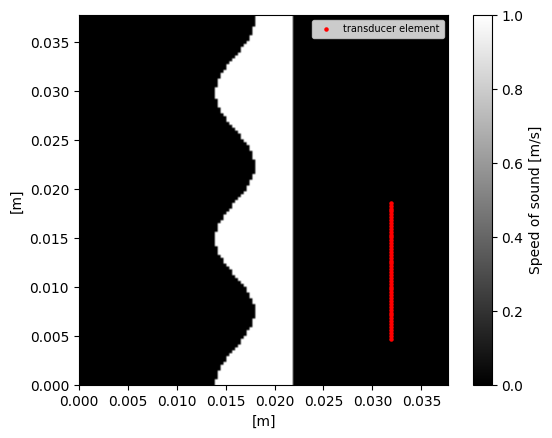

In [263]:
ext = [0, N[0]*dx[0], N[1]*dx[1], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
# plt.scatter((element_positions[1, nelements//2]-55)*dx[1], 
#             element_positions[0, nelements//2]*dx[0], 
#             c='b', marker='o', s=10)
plt.imshow(speed, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()